Let's try out some persistent homology (PH) computations, using the best software on the open-source market!

We will try to use the software recommended by [this recent survey](http://arxiv.org/abs/1506.08903), namely:

* DIPHA : https://code.google.com/p/dipha/
* GUDHI : http://gudhi.gforge.inria.fr/doc/1.1.0/

Both are C++ libraries which we will call using the shell. The actual data manipulation and exploitation of results will of course by in Python!

# Downloading and installing DIPHA and GUDHI

In [ ]:
%%bash
# We install first some dependencies; tested in Ubuntu 14.04
# Unfortunately this cannot really be run in the notebook because of the sudo... I cheated and used the terminal!
# DIPHA needs Open MPI
sudo apt-get install libopenmpi-dev

# GUDHI needs Boost
sudo apt-get install libboost-all-dev

Let us fetch the libraries:

First GUDHI

In [ ]:
%%bash
mkdir ../gudhi
wget -P ../gudhi https://gforge.inria.fr/frs/download.php/file/34396/Gudhi_library_1.1.0.zip
wget -P ../gudhi https://gforge.inria.fr/frs/download.php/file/34397/Gudhi_doc_1.1.0.zip
unzip -d ../gudhi ../gudhi/Gudhi_library_1.1.0.zip
unzip -d ../gudhi ../gudhi/Gudhi_doc_1.1.0.zip
rm ../gudhi/Gudhi_library_1.1.0.zip
rm ../gudhi/Gudhi_doc_1.1.0.zip

Let's have a look at what we just downloaded.

In [ ]:
!ls ../gudhi/Gudhi_library_1.1.0

We build the library

In [ ]:
%%bash
cd ../gudhi/Gudhi_library_1.1.0
mkdir build
cd build/
cmake -DCMAKE_BUILD_TYPE=Release ..
make

Not sure this has been built correctly since there is no main function in build/. However there are some functions built in the build/example folders which may do the work.

Now we do the same for DIPHA.

In [ ]:
%%bash
mkdir ../dipha
wget -P ../dipha https://docs.google.com/uc?id=0B7Yz6TPEpiGEYTZiMHkxZVpLUU0&export=download
unzip -P ../dipha ../dipha/uc?id=0B7Yz6TPEpiGEYTZiMHkxZVpLUU0
rm ../dipha/uc?id=0B7Yz6TPEpiGEYTZiMHkxZVpLUU0

In [ ]:
!ls ../dipha/dipha-2.1.0/

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0
mkdir build
cmake . 
make

# Downloading interesting datasets

Now that we have built the libraries, we can start using them. Let us gather some datasets which have proven interesting for PH in the litterature.

In [ ]:
%%bash
# Genomic datasets from Raul Rabadan's lab, notably the ones from the "Topology of viral evolution" paper, but also some more recent ones
mkdir ../datasets
cd ../datasets
git clone https://github.com/RabadanLab/ph_datasets.git
mv ph_datasets rabadan/

In [ ]:
!ls ../datasets/rabadan/pnas2013 

In [ ]:
%%bash
mv ../datasets/rabadan/pnas2013/avian_HA_nt_concat_jukes_cantor.csv  ../datasets/rabadan/pnas2013/HA.csv
mv ../datasets/rabadan/pnas2013/avian_all_nt_concat_jukes_cantor.csv ../datasets/rabadan/pnas2013/all.csv

# Reproducing some results of "Topology of viral evolution" using DIPHA

The datasets in pnas2013 are presented as distance matrices. Out-of-the box, only DIPHA seems to support it, so we'll run with that.

We have to do some work on the input files to make them compatible with the DIPHA distance matrix format. Namely, add "8067171840 7 number_of_input_points" in the correct binary format in the front, and convert all the floating point numbers to binary format as well.

Moreover, the original dataset is presented as a condensed distance matrix, whereas DIPHA requires (as far as I can tell??) a redundant distance matrix, but all flattened line by line. So we first have to do that conversion, for which we can thank scipy. 

In [ ]:
# There are two datasets, correspoding to distances computed using either one specific segment (HA) of the influenza genome or the concatenation of several relevant segments.
viral_HA_csv = "../datasets/rabadan/pnas2013/HA.csv"
viral_all_csv = "../datasets/rabadan/pnas2013/all.csv"
paths = [viral_HA_csv, viral_all_csv]
paths_sym = [path.rstrip(".csv") + ".sym" for path in paths]

N = 3105

In [ ]:
paths_sym

In [ ]:
import struct
import numpy as np
from scipy.spatial.distance import squareform

In [ ]:
for i in range(len(paths)):
    arr = np.loadtxt(paths[i], delimiter=',')
    dist = squareform(arr)
    dist.tofile(paths_sym[i], sep = ",")

In [ ]:
# Wrap the painful binary file manipulation into a function
magic = 8067171840
magic_bytes = magic.to_bytes(8, byteorder="little", signed=True)

In [ ]:
def sym_dist_to_dipha(input_matrix, dipha_output, n_points):
        import struct
        
        file_type = (7).to_bytes(8, byteorder="little")
                                 
        with open(input_matrix, "r") as f, open(dipha_output, "wb") as g:
            old = f.read()
            dist = old.split(',')
            dist_bytes = list(map(lambda fl: struct.pack('d',float(fl)), dist))
            g.write(magic_bytes)
            g.write(file_type)
            g.write(n_points.to_bytes(8, byteorder="little"))
            g.write(b''.join(dist_bytes))

In [ ]:
for spath in paths_sym:
    sym_dist_to_dipha(spath, spath.rstrip('.sym') + '.dipha', N)
    

We can finally launch DIPHA on the trail.

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0/
./dipha --upper_dim 2 ../../datasets/rabadan/pnas2013/HA.dipha ../../datasets/rabadan/pnas2013/HA_output.dipha


Unless I put upper_dim to be 1 (which only computes persistent H_0), I get some kind of memory error. Is the dataset too big? Let's make a toy dataset to find out. I edited a small 4*4 distance matrix in test.sym.

In [ ]:
sym_dist_to_dipha('test.sym', 'test.dipha', 4)

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0/
./dipha --upper_dim 3 ../../notebooks/test.dipha ../../notebooks/test_output.dipha

Yes, we definitely have a memory problem. Let us try to play with the option "--upper_value", with a "--benchmark" thrown in to have some insight on the memory usage.

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0/
./dipha --benchmark --upper_dim 2 --upper_value 1 ../../datasets/rabadan/pnas2013/HA.dipha ../../datasets/rabadan/pnas2013/HA_output.dipha


Conclusion: Dipha requires insane amounts of RAM for this task, at least for by my computer's standards (24Gb). I can't compute a single "value", whatever they are.

We only have one option left... "--dual" ! Another algorithm, maybe less memory intensive.

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0/
./dipha --benchmark --dual --upper_dim 2 --upper_value 1 ../../datasets/rabadan/pnas2013/HA.dipha ../../datasets/rabadan/pnas2013/HA_output.dipha


No, it's about as bad. We have to lower our ambitions and subsample the data. Let us try with a random, controlled fraction. 

With my configuration, I can go up to about 0.4 if going up to PH_1, and 0.1 if going up to PH_2. (In both cases, complexes with about 200*10^6 simplices).

In [ ]:
import random

def bernoulli(p):
    return random.random() <= p

fraction = 0.1

sample_indices = np.array([bernoulli(fraction) for i in range(N)])
N_sample = sample_indices.sum()

In [ ]:
def sym_dist(sym_mat, sample_output, indices):
    
    n_sample = indices.sum()
    
    arr = np.loadtxt(sym_mat, delimiter=',')
    sq_arr = arr.reshape(N,N)
    sample_sq_arr = sq_arr[:,indices][indices,:]
    sample_arr = sample_sq_arr.reshape(n_sample**2)
    
    sample_arr.tofile(sample_output, sep=',')        

In [ ]:
paths_sym_sample = [path.rstrip('.sym') + '_sample.sym' for path in paths_sym]

for path in paths_sym:
    subsample_sym_dist(path, path.rstrip('.sym') + '_sample.sym', sample_indices)

In [ ]:
paths_dipha_sample = [path.rstrip('.sym') + '.dipha' for path in paths_sym_sample]

for path in paths_sym_sample:
    sym_dist_to_dipha(path, path.rstrip('.sym') + '.dipha', int(N_sample))
    

We can now try to DIPHA this smaller dataset.

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0/
./dipha --benchmark --dual --upper_dim 3 ../../datasets/rabadan/pnas2013/HA_sample.dipha ../../datasets/rabadan/pnas2013/HA_sample_output.dipha

Here is a multiprocess version to speed things up; seems to provide only a 2x speedup even with 8 cores.

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0/
mpiexec -n 8 ./dipha --benchmark --dual --upper_dim 3 ../../datasets/rabadan/pnas2013/HA_sample.dipha ../../datasets/rabadan/pnas2013/HA_sample_output.dipha

In [ ]:
%%bash
cd ../dipha/dipha-2.1.0/
mpiexec -n 8 ./dipha --benchmark --dual --upper_dim 3 ../../datasets/rabadan/pnas2013/all_sample.dipha ../../datasets/rabadan/pnas2013/all_sample_output.dipha

In [ ]:
%%bash
mpiexec -n 8 --path ../dipha/dipha-2.10/ dipha --benchmark --dual --upper_dim 1 ../../datasets/rabadan/pnas2013/all_sample.dipha ../../datasets/rabadan/pnas2013/all_sample_output.dipha

The output is also binary, so we have to play the translation game in the other direction to save a numpy array.

In [ ]:
def dipha_output_to_npy(dipha_output, npy_file):
    with open(dipha_output, 'rb') as f:
        
        file_type = (2).to_bytes(8, byteorder="little")
        assert f.read(16) == magic_bytes + file_type
        
        import struct
        
        n_bars = struct.unpack('<q', f.read(8))[0]

        arr = np.zeros((n_bars,3))
        
        for i in range(n_bars):
            arr[i,0] = struct.unpack('<q', f.read(8))[0]
            arr[i,1] = struct.unpack('d', f.read(8))[0]
            arr[i,2] = struct.unpack('d', f.read(8))[0]
    
    np.save(npy_file, arr)
            
            
    

In [ ]:
dipha_output_to_npy("../datasets/rabadan/pnas2013/HA_sample_output.dipha", '../datasets/rabadan/pnas2013/HA_sample_output.npy')
dipha_output_to_npy("../datasets/rabadan/pnas2013/all_sample_output.dipha", '../datasets/rabadan/pnas2013/all_sample_output.npy')


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [37]:
pers_diag_HA = np.load('../datasets/rabadan/pnas2013/HA_sample_output.npy')
pers_diag_all = np.load('../datasets/rabadan/pnas2013/all_sample_output.npy')

In [ ]:
pers_diag_all[:,1]

In [11]:
# Plotting the persistence diagram for each Betti number

def plot_persistence_diagram(pers_diag):
    
    import matplotlib.pyplot as plt
    betti_nums = pers_diag[:,0]
    betti_max = betti_nums.max()
    
    x_coords = pers_diag[:,1]
    y_coords = pers_diag[:,2]
    
    size = max(max(x_coords), max(y_coords))
    
    fig,ax = plt.subplots()
    ax.scatter(pers_diag[:,1], pers_diag[:,2], c=betti_nums, s=40)
    plt.plot([0,size], [0,size], ls="--")

In [12]:
import matplotlib.pyplot as plt 

plot_persistence_diagram(pers_diag_HA)
plot_persistence_diagram(pers_diag_all)
plt.show()

NameError: name 'pers_diag_HA' is not defined

In [13]:
# Plotting the aggregate Betti curves

def plot_betti_curves(pers_diag):
    
    import matplotlib.pyplot as plt
    import numpy as np
    # Assumes the bars are sorted by birth points
    
    betti_nums = pers_diag[:,0]
    betti_max = int(betti_nums.max()) 
    
    max_x = max(pers_diag[:,2])
    
    fig,ax = plt.subplots()
    
    for i in range(betti_max+1):
        
        bars_ind = (betti_nums == i)
    
        n_bars = bars_ind.sum()
        min_coords = pers_diag[bars_ind,1]
        max_coords = pers_diag[bars_ind,2]
        
        x = [i*max_x/1000 for i in range(1000)]
        y = np.zeros(1000)
        
        # There are better algorithms. POITROAE.
        for k in range(1000):
            step = k*max_x/1000
            
            y[k] = len([j for j in range(n_bars) if min_coords[j]<= step and max_coords[j]> step ])
        
        ax.plot(x,y)
    
    plt.show()
        

In [14]:
plot_betti_curves(pers_diag_HA)
plot_betti_curves(pers_diag_all)

NameError: name 'pers_diag_HA' is not defined

Interestingly, the differences can be seen on a very small subsample.

# Wrapping everything in a function

In [3]:
# Function taking a numpy condensed distance array or a distance matrix and plotting the persistent homology

def dist_to_pers_plot(distances, input_type="condensed", 
                      upper_dim=2, n_cores=8, 
                      save_output=False, output_path=''):
    # TODO:
    # - capture the output of --benchmark and process it, e.g to print total number of simplices
    
    # Imports
    
    import numpy as np
    import struct
    import subprocess, os
    from scipy.spatial.distance import squareform
    
    # Transforming the input into a distance matrix
    if input_type == "condensed":
        dist_mat = squareform(distances)
    elif input_type == "matrix":
        dist_mat = distances
    else:
        raise

    # Flattening out dist_mat 
    input_size = dist_mat.shape[0] 
    dist = dist_mat.reshape(input_size**2)
    
    # Writing a temporary input file in binary dipha format
    temp_input_path = "./input.dipha"

    
    magic = 8067171840
    magic_bytes = magic.to_bytes(8, byteorder="little")
    file_type = (7).to_bytes(8, byteorder="little")
                                 
    with open(temp_input_path, "wb") as g:
        dist_bytes = list(map(lambda fl: struct.pack('d',float(fl)), dist))
        g.write(magic_bytes)
        g.write(file_type)
        g.write(input_size.to_bytes(8, byteorder="little"))
        g.write(b''.join(dist_bytes))

    # Calling DIPHA
    
    temp_output_path = "./output.dipha"
    
    dipha_path = "/home/simon/Documents/Data/TDA_programs/dipha/dipha-2.1.0/dipha"
     
    command_list = ["mpiexec", "-n", str(n_cores),
                    dipha_path, '--upper_dim', str(upper_dim), 
                    temp_input_path, temp_output_path]
    
    exit_code = subprocess.call(command_list)
    #subprocess.call(command_list, shell=True)
    
    # Translating the output into a numpy array
    with open(temp_output_path, 'rb') as f:
        
        file_type = (2).to_bytes(8, byteorder="little")
        assert f.read(16) == magic_bytes + file_type
        
        import struct
        
        n_bars = struct.unpack('<q', f.read(8))[0]

        pers_diag = np.zeros((n_bars,3))
        
        for i in range(n_bars):
            pers_diag[i,0] = struct.unpack('<q', f.read(8))[0]
            pers_diag[i,1] = struct.unpack('d', f.read(8))[0]
            pers_diag[i,2] = struct.unpack('d', f.read(8))[0]
    
    if save_output:
        np.save(output_path, pers_diag)
    
    # Deleting the temp files
    os.remove(temp_input_path)
    os.remove(temp_output_path)
    
    # Printing the results
    plot_persistence_diagram(pers_diag)
    plot_betti_curves(pers_diag)

# Artificial datasets

We try some artificial dataset generators from scikit learn.

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [6]:
from sklearn.datasets import make_swiss_roll, make_circles, make_checkerboard, make_s_curve, make_blobs
from scipy.spatial.distance import pdist


## Circles

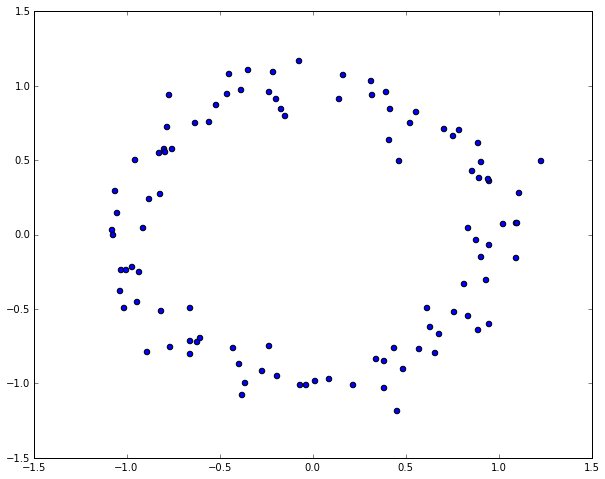

In [7]:
noisy_circle = make_circles(100, factor=1, noise=0.1)[0]
circle_dist = pdist(noisy_circle)

plt.scatter(noisy_circle[:,0], noisy_circle[:,1],s=30)

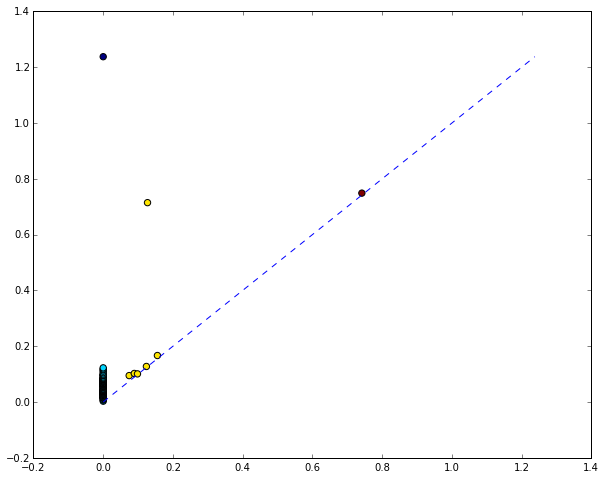

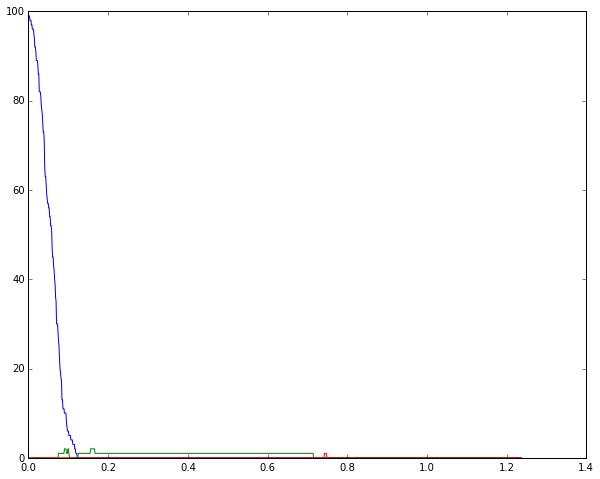

In [15]:
dist_to_pers_plot(circle_dist, upper_dim=3)

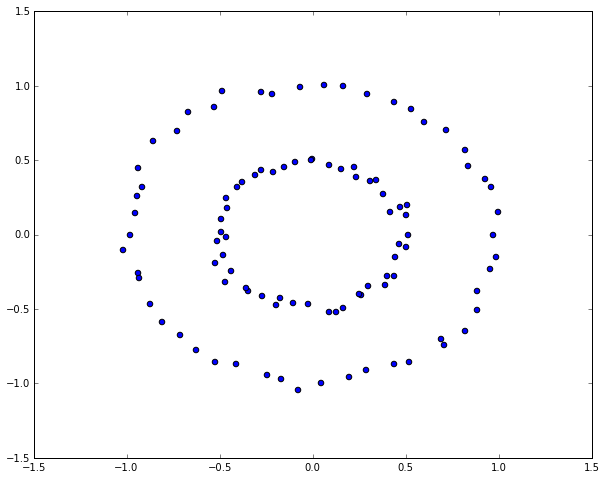

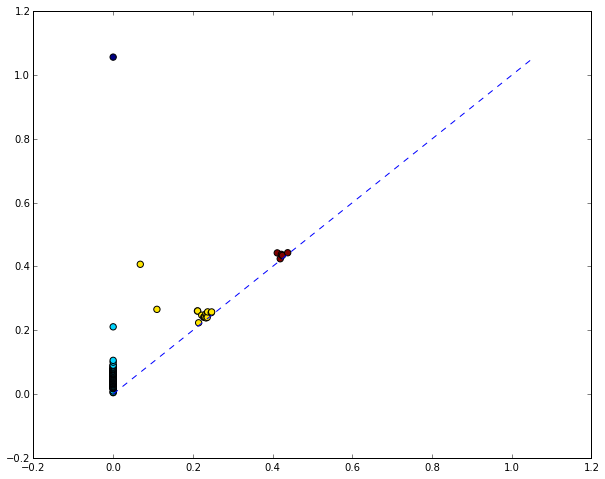

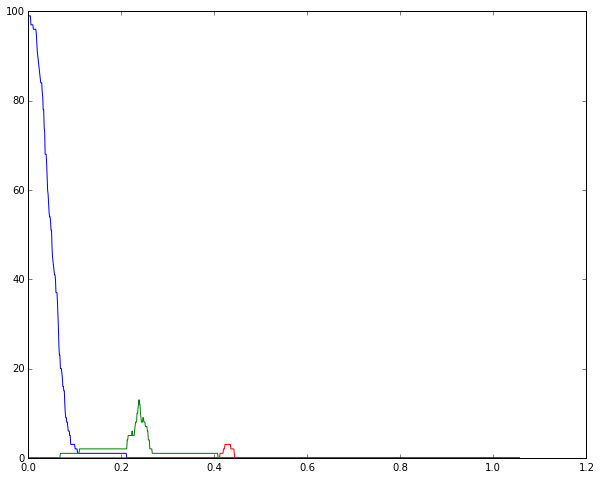

In [16]:
circles = make_circles(100, factor=0.5, noise=0.03)[0]
circles_dist = pdist(circles)

plt.scatter(circles[:,0], circles[:,1],s=30)

dist_to_pers_plot(circles_dist, upper_dim=3)

# High-dimensional Gaussian noise

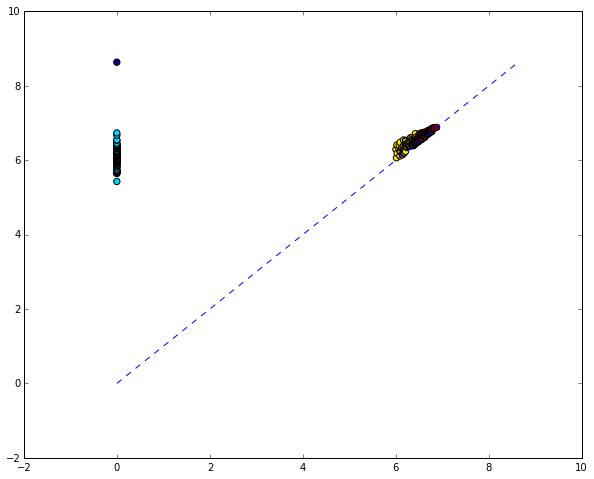

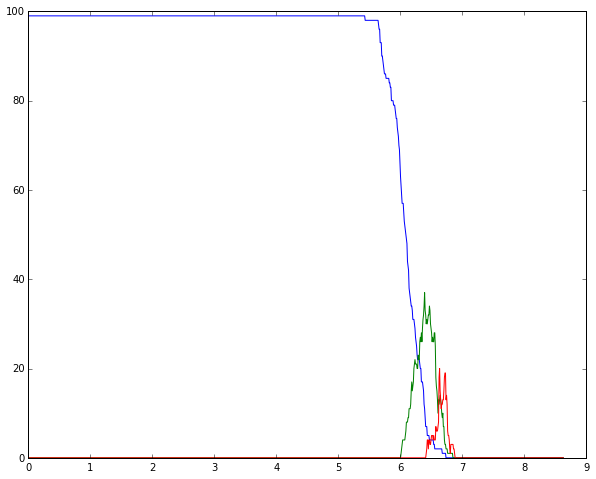

In [17]:
gaussian = make_blobs(n_samples=100, n_features=100, centers=1)[0]
gaussian_dist = pdist(gaussian)

dist_to_pers_plot(gaussian_dist, upper_dim=3)

## Swiss rolls

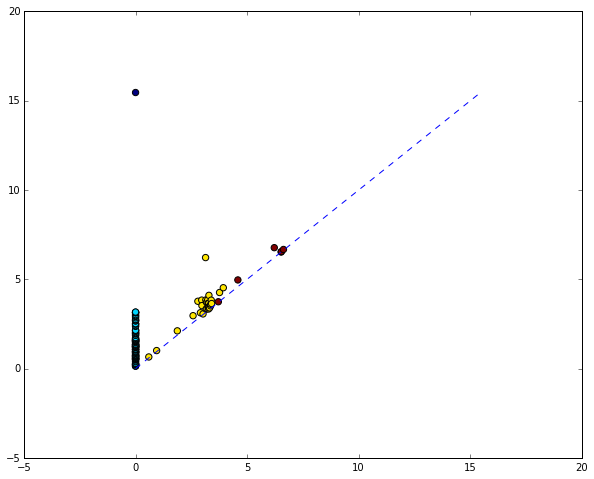

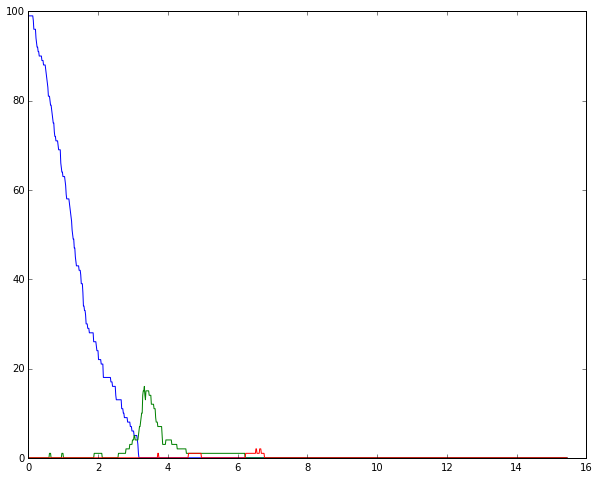

In [18]:
swiss_dist = pdist(make_swiss_roll(100)[0])

dist_to_pers_plot(swiss_dist, upper_dim=3)

In [ ]:
ls